#### Tracking training, engineering imporvement

In [1]:
from data.utils import to_dataloader, split, get_covid_dls
from data.xray_dataset import DEFAULT_TRANSFORMS, IMAGENET_NORMALIZE
import torchvision
from torchvision import transforms
from torch.utils.data.dataset import random_split
import torch
import pandas as pd
import os 
import matplotlib.pyplot as plt
from data.utils import plot_roc, plot_confusion_matrix, SEED
import numpy as np
import random 

from main import *
from utils import all_loss, all_opt
import torchvision.models as models
import seaborn as sns
torch.manual_seed(SEED)
ROOT_DIR = '../data/10_all_data_foldered/'
DATA_DIR = '../data/10_all_data_foldered/images'
IMG_DIR = DATA_DIR
tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300, 300)),
    transforms.RandomCrop((224, 224)),
    # transforms.RandomHorizontalFlip(0.1),
    transforms.RandomRotation(5),
    transforms.Resize((240,240)),
    transforms.ColorJitter(0.1, 0.1, 0, 0),
    ])

# pytorch from ImageFolder
# ds = torchvision.datasets.ImageFolder(DATA_DIR, transform=tfms)
# train, val = int(len(ds) *0.6), int(len(ds) *0.2)
# test = len(ds) - train - val
# datasets =  random_split(ds, [train, val, test])
df = pd.read_csv(os.path.join(ROOT_DIR, 'data.csv'))
no_ct = pd.read_csv(os.path.join(ROOT_DIR, 'no_ct.csv'))
i = 4

## Trying gender, age

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import imagehash
import cv2
from PIL import Image
import shutil
from data.utils import get_covid_dls, split

In [3]:
def new_labels(col):
    col = col.lower()
    if 'covid' in col:
        return 'covid-19'
    elif 'viral' in col:
        return 'viral_p'
    elif 'bacterial' in col:
        return 'bacterial_p'
    elif 'fungal' in col:
        return 'fungal_p'
    elif 'no finding' in col:
        return 'normal'
    return 'others'

def age_bin(col):
    segments = [-1,30,60, 1000]
    segments = segments[::-1]
    return str(next(3 - i for i,a in enumerate(segments) if int(col) > a))

In [4]:
ALL_DIR = '../data/10_all_data_foldered/'
no_ct = pd.read_csv(os.path.join(ALL_DIR, 'no_ct.csv'))
no_ct['label_age'] = ''
no_ct['label_gender'] = ''
normal_df = no_ct[no_ct['label'] == 1][:150]
vp_df = no_ct[no_ct['label'] == 2][:150]
normal_df.loc[:, ['label', 'label_age', 'label_gender']] = 'normal'
vp_df.loc[:, ['label', 'label_age', 'label_gender']] = 'viral_p'


In [5]:
# df['short-finding'] = df['finding'].apply(lambda x: x.split('/')[-1])
df = pd.read_csv('../data/01_ieee-covid-chestxray-dataset/metadata.csv')
df = df[(df['modality'] =='X-ray') & (df['view'] != 'L')]
df = df[~df['age'].isna() & ~df['sex'].isna()] 
df['label'] = df['finding'].apply(new_labels)
df = df[df['label'] != 'others']
processed_df = df[(df['label'] != 'fungal_p') & (df['label'] != 'bacterial_p')]
processed_df['label_gender'] = processed_df['label'] + '-' + processed_df['sex']
processed_df['agegroup'] = processed_df['age'].apply(age_bin)
processed_df['label_age'] = processed_df['label'] + '-' + processed_df['agegroup']
processed_df['label_age'] = processed_df['label_age'].apply(lambda d: d if 'covid' in d else d.split('-')[0])
processed_df['label_gender'] = processed_df['label_gender'].apply(lambda d: d if 'covid' in d else d.split('-')[0])

cnv_df = processed_df[['filename', 'label', 'label_gender', 'label_age']]
cnv_df = cnv_df.append([vp_df, normal_df])
split_df = split(cnv_df, test_pct=0, val_pct=0.4)

<AxesSubplot:title={'center':'Metadata Gender label subclass'}, xlabel='label_gender', ylabel='Count'>

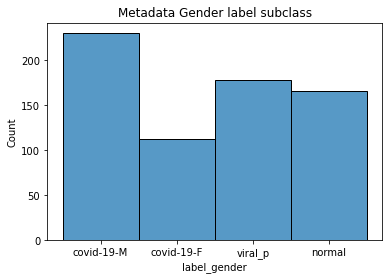

In [6]:
plt.title('Metadata Gender label subclass')
sns.histplot(split_df['label_gender'])

In [14]:
from main import *
import pandas as pd
from utils.functions import class_weights
from utils import all_loss, all_opt
import torchvision.models as models
import arch
import os
osjoin = os.path.join
i = 0
arch.NUM_CLASSES = 3
dls = get_covid_dls(64, split_df, 'filename', 'label', root='../data/01_ieee-covid-chestxray-dataset/images', reg=True)
model_name = 'resnet18'
exp_name = osjoin('report', 'ieee-merged')
os.makedirs(osjoin('model_weights', exp_name), exist_ok=True)
hp = {**DEFAULT_HP, 'model_name': f'label_{model_name}_224_{i+1}'}
trng_labels = dls[0].dataset.labels
# weights = class_weights(torch.stack(trng_labels)) 
trainer2 = Trainer(exp_name, model_name, dls, hp, weights=None, sched=True)
trainer2.load_weights(f'label_{model_name}_224_{i}.pkl')
try:
    # trainer2.one_cycle()
    pass
except Exception as err:
    print(err)

all_recall [0.92907801 0.9        0.85714286]
f1_score 0.9051770344239997
weighted_recall 0.9051094890510949
C:\Users\ngbra\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\ranking.py:103: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
C:\Users\ngbra\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


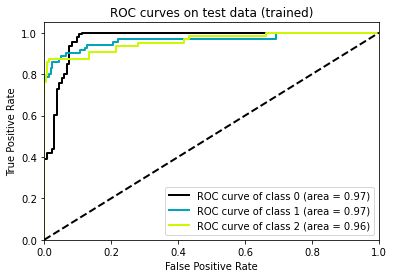

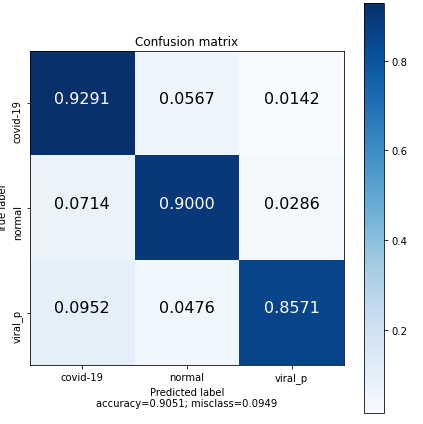

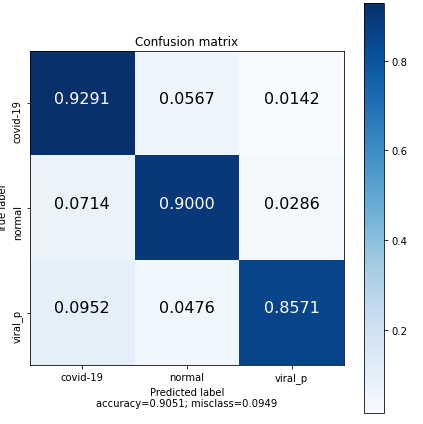

In [30]:
trainer2.cms[1] = None
preds, labels = trainer2.confusion_matrix_auc(1)
plot_roc(labels, preds)
plot_confusion_matrix(trainer2.cms[1], trainer2.class_names)

### Age

In [17]:
from main import *
import pandas as pd
from utils.functions import class_weights
from utils import all_loss, all_opt
import torchvision.models as models
import arch
import os
osjoin = os.path.join
i = '30-60'
arch.NUM_CLASSES = 3
dls = get_covid_dls(64, split_df, 'filename', 'label_age', root='../data/01_ieee-covid-chestxray-dataset/images', reg=True)
model_name = 'resnet34'
exp_name = osjoin('report', 'ieee-merged')
hp = {**DEFAULT_HP, 'model_name': f'age_{model_name}_224_{i}'}
trng_labels = dls[0].dataset.labels
# weights = class_weights(torch.stack(trng_labels)) 
trainer = Trainer(exp_name, model_name, dls, hp, weights=None, sched=True)
trainer.load_weights(f'../../report_all/{model_name}_224_{0}.pkl', num_classes=5, family='resnet')

In [18]:
try:
    trainer.one_cycle()
except Exception as err:
    print(err)

  0%|          | 0/5 [00:00<?, ?it/s]
epoch trng info: loss:1.4714627265930176, acc:0.36009732360097324
  0%|          | 0/7 [00:00<?, ?it/s]
epoch val info: loss:1.2042874097824097, acc:0.4854014598540146
epoch number: 1
  0%|          | 0/5 [00:00<?, ?it/s]
epoch trng info: loss:0.9929362535476685, acc:0.6885644768856448
  0%|          | 0/7 [00:00<?, ?it/s]
epoch val info: loss:0.9150541424751282, acc:0.5291970802919708
epoch number: 2
  0%|          | 0/5 [00:00<?, ?it/s]
epoch trng info: loss:0.7979509830474854, acc:0.7761557177615572
100%|██████████| 5/5 [00:11<00:00,  2.32s/it]

epoch val info: loss:0.8552040457725525, acc:0.5766423357664233
  0%|          | 0/5 [00:00<?, ?it/s]

epoch trng info: loss:0.7274075150489807, acc:0.7956204379562044
  0%|          | 0/7 [00:00<?, ?it/s]
epoch val info: loss:0.810029149055481, acc:0.6277372262773723
epoch number: 4
  0%|          | 0/5 [00:00<?, ?it/s]
epoch trng info: loss:0.7410953044891357, acc:0.7858880778588808
100%|██████████| 5/

all_recall [0.33333333 0.19672131 0.64615385 0.82857143 0.87301587]
f1_score 0.6360349153422289
weighted_recall 0.6277372262773723
C:\Users\ngbra\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\ranking.py:103: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
C:\Users\ngbra\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


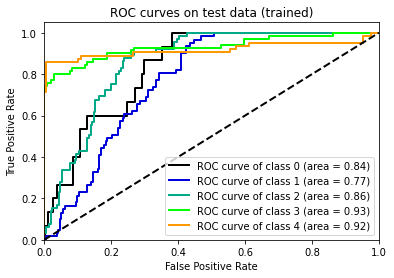

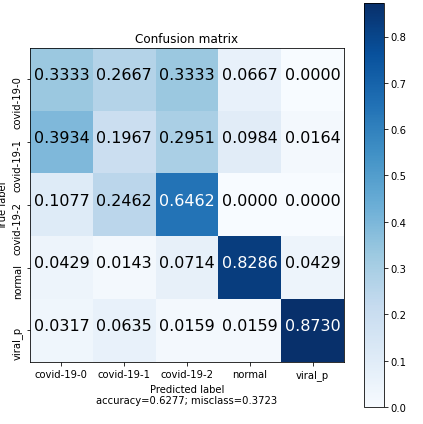

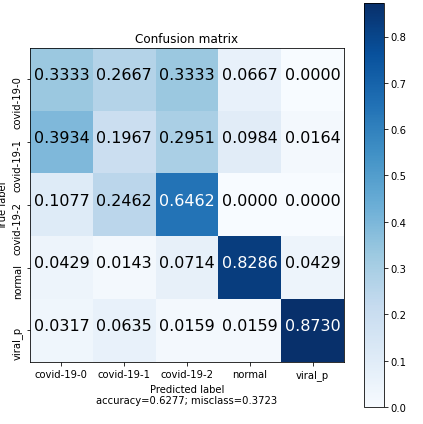

In [20]:
from data.utils import plot_confusion_matrix, plot_roc

trainer.cms[1] = None
preds, labels = trainer.confusion_matrix_auc(1)
plot_roc(labels, preds)
plot_confusion_matrix(trainer.cms[1], trainer.class_names)

### Gender

In [11]:
from main import *
import pandas as pd
from utils.functions import class_weights
from utils import all_loss, all_opt
import torchvision.models as models
import arch
import os
osjoin = os.path.join
i = 1
arch.NUM_CLASSES = 4
dls = get_covid_dls(64, split_df, 'filename', 'label_gender', root='../data/01_ieee-covid-chestxray-dataset/images', reg=True)
model_name = 'resnet18'
exp_name = osjoin('report', 'ieee-merged')
hp = {**DEFAULT_HP, 'model_name': f'gender_{model_name}_224_{i+1}'}
trng_labels = dls[0].dataset.labels
# weights = class_weights(torch.stack(trng_labels)) 
trainer3 = Trainer(exp_name, model_name, dls, hp, weights=None, sched=True)
trainer3.load_weights(f'gender_{model_name}_224_{i}.pkl')
try:
    trainer3.one_cycle()
except Exception as err:
    print(err)

  0%|          | 0/5 [00:00<?, ?it/s]
epoch trng info: loss:0.4151650071144104, acc:0.8807785888077859
  0%|          | 0/7 [00:00<?, ?it/s]
epoch val info: loss:0.6092022061347961, acc:0.7262773722627737
epoch number: 1
  0%|          | 0/5 [00:00<?, ?it/s]
epoch trng info: loss:0.3966650664806366, acc:0.902676399026764
  0%|          | 0/7 [00:00<?, ?it/s]
epoch val info: loss:0.7101407647132874, acc:0.6897810218978102
epoch number: 2
  0%|          | 0/5 [00:00<?, ?it/s]
epoch trng info: loss:0.4647972583770752, acc:0.8467153284671532
  0%|          | 0/7 [00:00<?, ?it/s]
epoch val info: loss:0.6810052990913391, acc:0.6934306569343066
epoch number: 3
  0%|          | 0/5 [00:00<?, ?it/s]
epoch trng info: loss:0.4946020245552063, acc:0.851581508515815
  0%|          | 0/7 [00:00<?, ?it/s]
epoch val info: loss:0.6229581236839294, acc:0.7153284671532847
epoch number: 4
  0%|          | 0/5 [00:00<?, ?it/s]
epoch trng info: loss:0.39235919713974, acc:0.8832116788321168
100%|██████████| 

C:\Users\ngbra\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


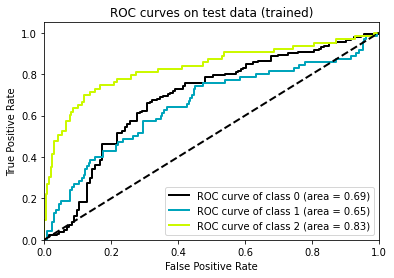

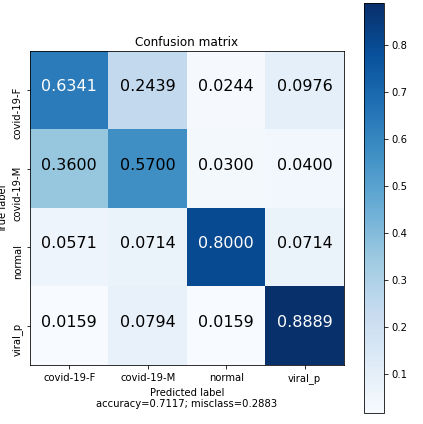

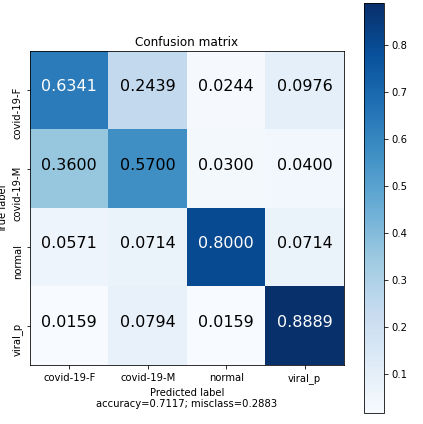

In [21]:
# trainer3.cms[1] = None
# preds, labels = trainer3.confusion_matrix_auc(1)
plot_roc(labels, preds)
plot_confusion_matrix(trainer3.cms[1], trainer3.class_names)

## Working with class decomposition, DeTrunc model

In [5]:
from data.utils import to_dataloader, split
from data.xray_dataset import DEFAULT_TRANSFORMS, IMAGENET_NORMALIZE
import torchvision
from torchvision import transforms
from torch.utils.data.dataset import random_split
import torch
import pandas as pd
import os 
from arch import all_models
# CPA + kmeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
import cv2
from data.xray_dataset import XrayDataset

ROOT_DIR = '../data/10_all_data_foldered/'
DATA_DIR = '../data/10_all_data_foldered/images'
IMG_DIR = DATA_DIR
tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    IMAGENET_NORMALIZE
])

df_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    IMAGENET_NORMALIZE
])

# pytorch from ImageFolder
df2 = pd.read_csv(os.path.join(ROOT_DIR, 'no_ct.csv'))
ds = torchvision.datasets.ImageFolder(DATA_DIR, transform=tfms)
ds_df = XrayDataset(DATA_DIR, 'filename', 'label', df2, train=False)

## Generating dataframe so that we can append the new label

In [14]:
# rows = []
# for filepath, label in ds.imgs:
#     filepath = filepath[36:]
#     rows.append((filepath, label))
# df2 = pd.DataFrame(rows, columns=['filename', 'label'])
# df2.to_csv(os.path.join("../data/10_all_data_foldered/", 'data.csv'), index=False)

In [7]:
## Checking equivalence of df_dataset and normal dataset after using pytorch random_split
def check_equal(ds2, ds1, idx):
    print(ds1.dataset.imgs[idx])
    print(ds2.dataset.filepaths[idx])
    assert (ds1[idx][0] != ds2[idx][0]).sum() == 0
# check_equal(datasets_df[0], datasets[0], 0)

def get_features(ds, model):
    dl = to_dataloader(ds, bs=64)
    all_features = torch.tensor([]).cuda()
    with torch.no_grad():
        for xb, _ in dl:
            xb = xb.cuda()
            all_features = torch.cat([all_features, model(xb)])
            xb.cpu()
    return all_features

def cluster_and_plot(features, variance=0.95, type=0, max_clusters=4):
    all_features = [features[:731], features[731:731+1358], features[731+1358:]]
    curr = all_features[type]
    pca = PCA(variance)
    all_pcaed = pca.fit_transform(curr.cpu().numpy())
    print(all_pcaed.shape)
    best_k = 0
    inertias = []
    for i in range(2, max_clusters):
        cluster_fn = KMeans(n_clusters=i, random_state=0, max_iter=300)
        k_clusters = cluster_fn.fit_transform(all_pcaed)
        inertias.append(cluster_fn.inertia_)
    inertia_diff = [inertias[i+1] - inertias[i] for i in range(len(inertias)-1)]
    k = inertia_diff.index(max(inertia_diff)) + 3
    return k
    cluster_fn = KMeans(n_clusters=k, random_state=0)
    k_clusters = cluster_fn.fit_transform(all_pcaed)
    # this is to get the sum of squared distance within each cluster
    sns.histplot(np.argmax(k_clusters, axis=1))
    
def get_subclasses(features, classes=[4,1,4], variance=0.95):
    covid, normal, vp = features[:731], features[731:731+1358], features[731+1358:]
    new_labels = []
    temp = 0
    for i, c in enumerate([covid, normal, vp]):
        pca = PCA(variance)
        all_pcaed = pca.fit_transform(c.cpu().numpy())
        inertias = []
        for s in range(43):
            cluster_fn = KMeans(n_clusters=classes[i], random_state=s)
            k_clusters = cluster_fn.fit_transform(all_pcaed)
            inertias.append(cluster_fn.inertia_)
        min_s = inertias.index(min(inertias))
        cluster_fn = KMeans(n_clusters=classes[i], random_state=min_s)
        k_clusters = cluster_fn.fit_transform(all_pcaed)
        new_labels.append(np.argmax(k_clusters, axis=1) + (0 if i == 0 else temp))
        temp += classes[i]
        sns.histplot(np.argmax(k_clusters, axis=1), color=sns.color_palette()[i])
    return new_labels

## Headless models

In [6]:
import arch
arch.NUM_CLASSES = 3
r50 = all_models['resnet50']()
r50.fc = torch.nn.Linear(2048, 3)
# r50.load_state_dict(torch.load('./model_weights/balanced/resnet50_224_1.pkl'))
r50.classifier = torch.nn.Sequential(*list(r50.children())[:-1])

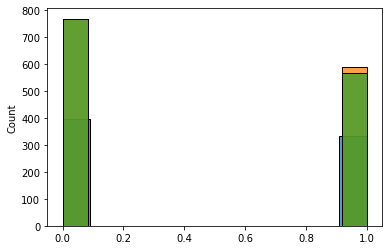

In [8]:
r34 = all_models['resnet34']()
r34.fc = torch.nn.Linear(512, 3)
r34.load_state_dict(torch.load('./model_weights/report_all/resnet34_224_0.pkl'))
r34 = torch.nn.Sequential(*list(r34.children())[:-1], torch.nn.Flatten())
r34_features = get_features(ds_df, r34.cuda())

# for i in range(3):
#     print(cluster_and_plot(r34_features, type=i, max_clusters=2))
r34_labels = get_subclasses(r34_features, classes=[2,2,2])
r34_labels = np.concatenate(r34_labels)
df2['new_label'] = r34_labels

In [7]:
# vgg16 = all_models['vgg16']()
# vgg16.classifier = torch.nn.Sequential(*list(vgg16.classifier.children())[:-3])

# Get best k for clustering
# vgg16_raw_features = get_features(ds_df, vgg16.cuda())
# for i in range(3):
#     print(cluster_and_plot(vgg16_raw_features, type=i, max_clusters=8))
# vgg16_raw_labels = get_subclasses(vgg16_raw_features, classes=[3,2,3])
# vgg16_raw_labels = np.concatenate(vgg16_raw_labels)
# df2['new_label'] = vgg16_raw_labels

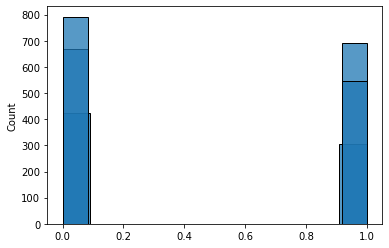

In [57]:
vgg16_trained = all_models['vgg16']()
vgg16_trained.classifier = torch.nn.Sequential(*list(vgg16_trained.classifier.children())[:-3])
vgg16_trained.load_state_dict(torch.load('./model_weights/report/vgg16_224_reg_4.pkl'))
# Get best k for clustering
vgg16_trained_features = get_features(ds_df, vgg16_trained.cuda())
for i in range(3):
    print(cluster_and_plot(vgg16_trained_features, type=i, max_clusters=6))
# vgg16_trained_new_classes = get_subclasses(vgg16_trained_features, classes=[2,2,2])
# vgg16_trained_new_classes = np.concatenate(vgg16_trained_new_classes)
# df2['new_label'] = vgg16_trained_new_classes

<AxesSubplot:xlabel='new_label', ylabel='Count'>

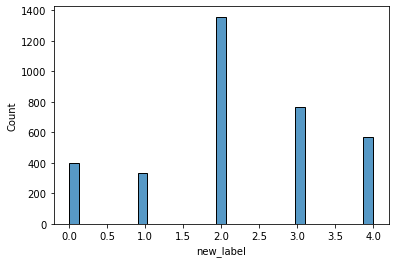

In [15]:
sns.histplot(df2['new_label'])

## TSNE visualization 
we will be looking at the vgg features

In [4]:
from sklearn.manifold import TSNE
# from cuml.manifold import TSNE

X_embedded = vgg16_raw_features.cpu().numpy()
X_embedded = TSNE(n_components=3, verbose=1, perplexity=50).fit_transform(X_embedded)
y_train = df2['new_label']

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3427 samples in 0.940s...
[t-SNE] Computed neighbors for 3427 samples in 76.440s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3427
[t-SNE] Computed conditional probabilities for sample 2000 / 3427
[t-SNE] Computed conditional probabilities for sample 3000 / 3427
[t-SNE] Computed conditional probabilities for sample 3427 / 3427
[t-SNE] Mean sigma: 14.921833
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.010429
[t-SNE] KL divergence after 850 iterations: 1.930790


KeyError: 'new_label'

<Figure size 432x288 with 0 Axes>

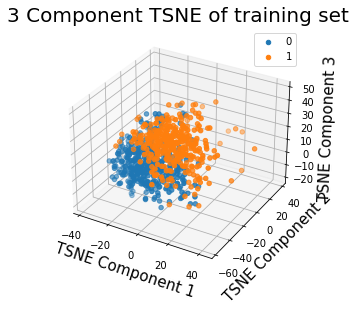

<Figure size 432x288 with 0 Axes>

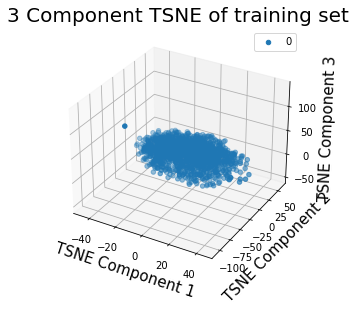

<Figure size 432x288 with 0 Axes>

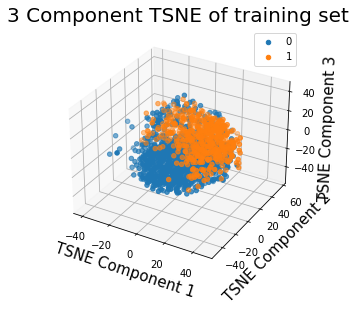

In [29]:
import matplotlib.pyplot as plt
y_train = df2['new_label']
y_train = df2['label']
X_embedded = 

def plot_tsne(embeddings, y_train, labels, i, z=True):
    color = ['red', 'green', 'blue']
    fig = plt.figure()
    fig = plt.figure(figsize = (15,15))
    if z:
        ax = fig.add_subplot(1,3,i, projection='3d')
    else:
        ax = fig.add_subplot(1,3,i)
    ax.set_xlabel('TSNE Component 1', fontsize = 15)
    ax.set_ylabel('TSNE Component 2', fontsize = 15)
    if z:
        ax.set_zlabel('TSNE Component 3', fontsize = 15)

    ax.set_title('3 Component TSNE of training set', fontsize = 20)
    for i in labels:
        f = embeddings[np.where(np.array(y_train)==i)]
        if z:
            ax.scatter3D(f[:,0],f[:,1],f[:,2])
        else:
            ax.scatter(f[:,0],f[:,1])

    legend = list(range(len(set(labels))))
    plt.legend(legend)
    plt.show()

for i, l in enumerate([[0,1,2]]):
    plot_tsne(X_embedded, y_train, l, i+1, True)

## DeTrunc training with VGG16 pretrained features

In [1]:
from data.utils import to_dataloader, split, get_covid_dls, plot_confusion_matrix, plot_roc
from data.xray_dataset import DEFAULT_TRANSFORMS, IMAGENET_NORMALIZE
import torchvision
from torchvision import transforms
from torch.utils.data.dataset import random_split
import torch
import pandas as pd
import os 
import arch
from arch import all_models
# CPA + kmeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
import cv2
from data.xray_dataset import XrayDataset

#! Setting NUM_CLASSES according to detrunc setting

ROOT_DIR = '../data/10_all_data_foldered/'
DATA_DIR = '../data/10_all_data_foldered/images'
IMG_DIR = DATA_DIR

# pytorch from ImageFolder
# df2 = pd.read_csv(os.path.join(ROOT_DIR, 'data_detrunc.csv'))
# arch.NUM_CLASSES = len(set(df2['new_label']))

# ds = torchvision.datasets.ImageFolder(DATA_DIR, transform=tfms)
# ds_df = XrayDataset(DATA_DIR, 'filename', 'new_label', df2)
# train, val = int(len(ds) *0.6), int(len(ds) *0.2)
# test = len(ds) - train - val
# SEED = 0
# torch.manual_seed(SEED)
# datasets =  random_split(ds, [train, val, test])
# SEED = 0
# torch.manual_seed(SEED)
# datasets_df =  random_split(ds_df, [train, val, test])
# dls = list(map(lambda d: to_dataloader(d, bs=64), datasets_df))

In [3]:
# df2.to_csv('../data/detrunc/r34_trained_222.csv', index=False)
df2 = pd.read_csv('../data/detrunc/vgg_trained_222.csv')
dls = get_covid_dls(128, df2, 'filename', 'new_label', root=DATA_DIR, reg=True)

In [4]:
from main import DEFAULT_HP, Trainer
arch.NUM_CLASSES=6
model_name = 'resnet34'
exp_name = 'detrunc'
hp = {**DEFAULT_HP, 'model_name': f'{model_name}_224_222', 'epochs':5}
trainer = Trainer(exp_name, model_name, dls, hp)

In [5]:
trainer.one_cycle()

  0%|          | 0/6 [00:00<?, ?it/s]
epoch trng info: loss:1.2999099493026733, acc:0.4526008750607681
  0%|          | 0/17 [00:00<?, ?it/s]
epoch val info: loss:0.911203145980835, acc:0.5553935860058309
epoch number: 1
  0%|          | 0/6 [00:00<?, ?it/s]
epoch trng info: loss:0.7145987153053284, acc:0.6767136606708799
100%|██████████| 6/6 [00:15<00:00,  2.67s/it]

epoch val info: loss:0.7407245635986328, acc:0.6443148688046647
  0%|          | 0/6 [00:00<?, ?it/s]
epoch trng info: loss:0.5625223517417908, acc:0.7715119105493436
  0%|          | 0/17 [00:00<?, ?it/s]
epoch val info: loss:0.6747419834136963, acc:0.6836734693877551
epoch number: 3
  0%|          | 0/6 [00:00<?, ?it/s]
epoch trng info: loss:0.5184264183044434, acc:0.7758872143898882
  0%|          | 0/17 [00:00<?, ?it/s]
epoch val info: loss:0.6527548432350159, acc:0.6895043731778425
epoch number: 4
  0%|          | 0/6 [00:00<?, ?it/s]
epoch trng info: loss:0.5159421563148499, acc:0.7817209528439475
  0%|          | 0

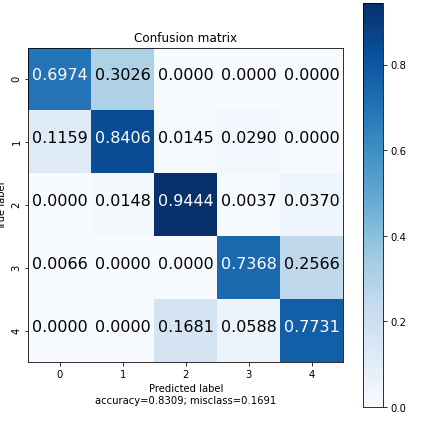

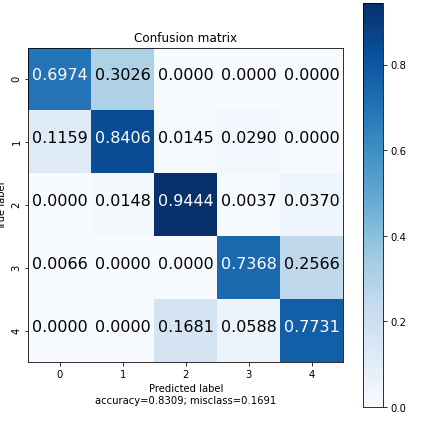

In [21]:
plot_confusion_matrix(trainer.cms[1], trainer.class_names)

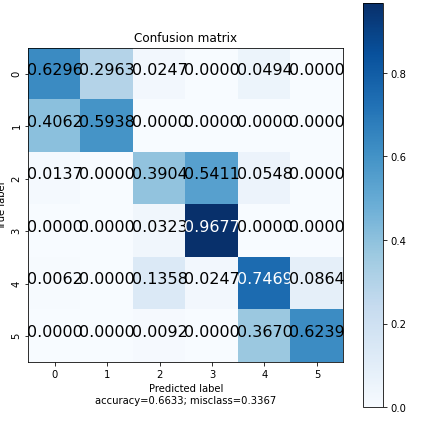

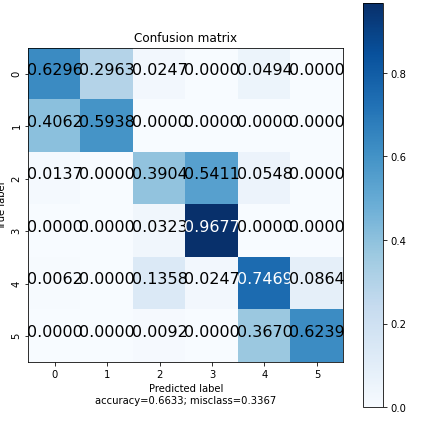

In [54]:
# trainer.cms[1] = None
# preds, labels = trainer.confusion_matrix_auc(1)
# plot_roc(labels, preds)
plot_confusion_matrix(trainer.cms[1], trainer.class_names)

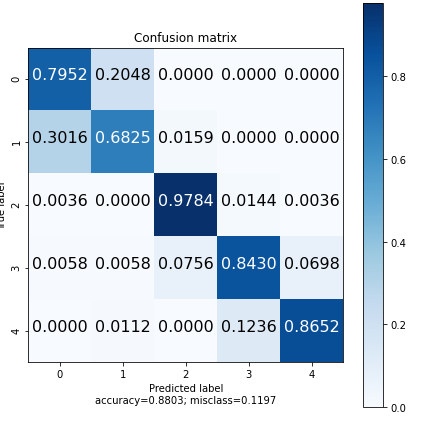

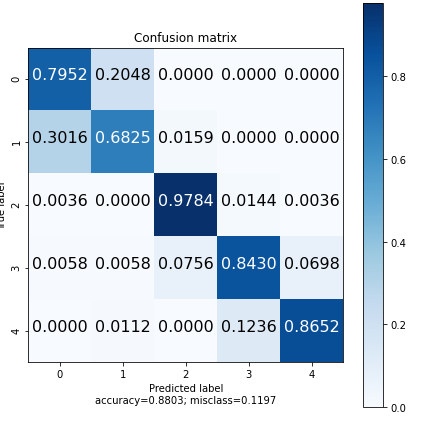

In [30]:
plot_confusion_matrix(trainer.cms[1], trainer.class_names)

<AxesSubplot:ylabel='Count'>

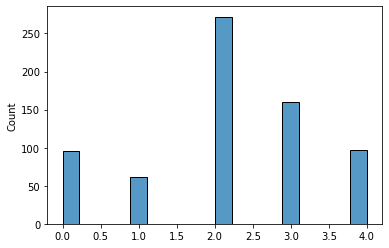

In [21]:
train_indices = np.asarray(datasets_df[2].indices)
sns.histplot(torch.stack(ds_df.labels)[train_indices].numpy())

## R18 without finetuning

In [ ]:
r18_features = get_features(ds_df, r18.cuda())
r18_new_labels = get_subclasses(r18_features, classes=[2,1,2])
r18_new_labels = np.concatenate(r18_new_labels)
df2['new_label'] = r18_new_labels

In [ ]:
import arch
from main import *
from data.utils import class_weights
arch.NUM_CLASSES = 5
ds_df = XrayDataset(DATA_DIR, 'filename', 'new_label', df2)
cw = class_weights(torch.stack(ds_df.labels))
train, val = int(len(ds) *0.6), int(len(ds) *0.2)
test = len(ds) - train - val
SEED = 0
torch.manual_seed(SEED)
datasets =  random_split(ds_df, [train, val, test])
dls = list(map(lambda d: to_dataloader(d, bs=64), datasets))
model_name = 'resnet18'
exp_name = 'detrunc'
hp = {**DEFAULT_HP, 'model_name': f'{model_name}_224'}
trainer = Trainer(exp_name, model_name, dls, hp, cw.cuda())

In [ ]:
trainer.one_cycle()

In [ ]:
trainer.cms[1]

## R18 with finetuning

In [ ]:
# covid [:807], normal [807:807+1358], vp [807+1358:]
covid, normal, vp = r18_features[:807], r18_features[807:807+1358], r18_features[807+1358:]
pca = PCA(0.95)
all_pcaed = pca.fit_transform(covid.cpu().numpy())
print(all_pcaed.shape)
cluster_fn = KMeans(n_clusters=3, random_state=0)
k_clusters = cluster_fn.fit_transform(all_pcaed)
sns.histplot(np.argmax(k_clusters, axis=1))

## r50 with finetuing

In [ ]:
np.argmax(k_clusters, axis=1)[:-7].reshape(-1, 16)